<a href="https://colab.research.google.com/github/evan-person/BER_Prediction_UWAcousticCommunication_Oceans2020/blob/master/Oceans2020_SupervisedLearningForUWAComm_LucasWang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python Notebook for analyzing data and generating figures for Oceans 2020 paper: Supervised Learning for Performance Prediction in Underwater Acoustic Communications by Evan Lucas and Zhaohui Wang

Evan Lucas


## Prep work - loading data and libraries

Copy data from github

In [ ]:
! git clone https://github.com/evan-person/BER_Prediction_UWAcousticCommunication_Oceans2020.git

Cloning into 'BER_Prediction_UWAcousticCommunication_Oceans2020'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 53 (delta 19), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (53/53), done.


In [ ]:
! unzip -q ./BER_Prediction_UWAcousticCommunication_Oceans2020/preprocessedSPACE08.zip -d  ./SPACE08 

In [ ]:
!pip install git+https://github.com/scikit-learn-contrib/skope-rules.git

  Cloning https://github.com/scikit-learn-contrib/skope-rules.git to /tmp/pip-req-build-3so5fre7
  Running command git clone -q https://github.com/scikit-learn-contrib/skope-rules.git /tmp/pip-req-build-3so5fre7
  Created wheel for skope-rules: filename=skope_rules-1.0.0-cp36-none-any.whl size=14927 sha256=07b276926c671ae0f9633945c6bd78bdfbaa39c025eec446584febf91c460cba
  Stored in directory: /tmp/pip-ephem-wheel-cache-jifw_eth/wheels/37/a1/cb/673887b1442bee8e457936a3299a9184816121c52be7273186
Successfully built skope-rules


Load libraries

In [ ]:
import csv
import os
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn import tree
from imblearn.over_sampling import SMOTE
import graphviz
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_approximation import RBFSampler

from skrules import SkopeRules

from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
from google.colab import files
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

from sklearn.neighbors import KNeighborsRegressor


from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor


from google.colab import files

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Index all the data files and list their filenames

In [ ]:
! ls ./SPACE08
dataFiles = os.listdir('./SPACE08')


16qamDataS1.csv  16qamDataS6.csv  8qamDataS5.csv   qpskDataS3.csv
16qamDataS2.csv  8qamDataS1.csv   8qamDataS6.csv   qpskDataS4.csv
16qamDataS3.csv  8qamDataS2.csv   KWAUG14data.csv  qpskDataS5.csv
16qamDataS4.csv  8qamDataS3.csv   qpskDataS1.csv   qpskDataS6.csv
16qamDataS5.csv  8qamDataS4.csv   qpskDataS2.csv


Take a first look at the data dimensions and make a pairplot to see how some key features vary

8qamDataS5.csv
(19902, 6)
qpskDataS1.csv
(42240, 6)
8qamDataS4.csv
(28307, 6)
16qamDataS5.csv
(19870, 6)
8qamDataS6.csv
(20355, 6)
16qamDataS4.csv
(28289, 6)
8qamDataS1.csv
(42158, 6)
8qamDataS2.csv
(37050, 6)
qpskDataS5.csv
(19879, 6)
qpskDataS6.csv
(20347, 6)
qpskDataS3.csv
(28312, 6)
16qamDataS6.csv
(20311, 6)
16qamDataS3.csv
(28319, 6)
16qamDataS1.csv
(42255, 6)
KWAUG14data.csv
(8660, 4)
qpskDataS2.csv
(37079, 6)
16qamDataS2.csv
(36896, 6)
qpskDataS4.csv
(28310, 6)
8qamDataS3.csv
(28319, 6)


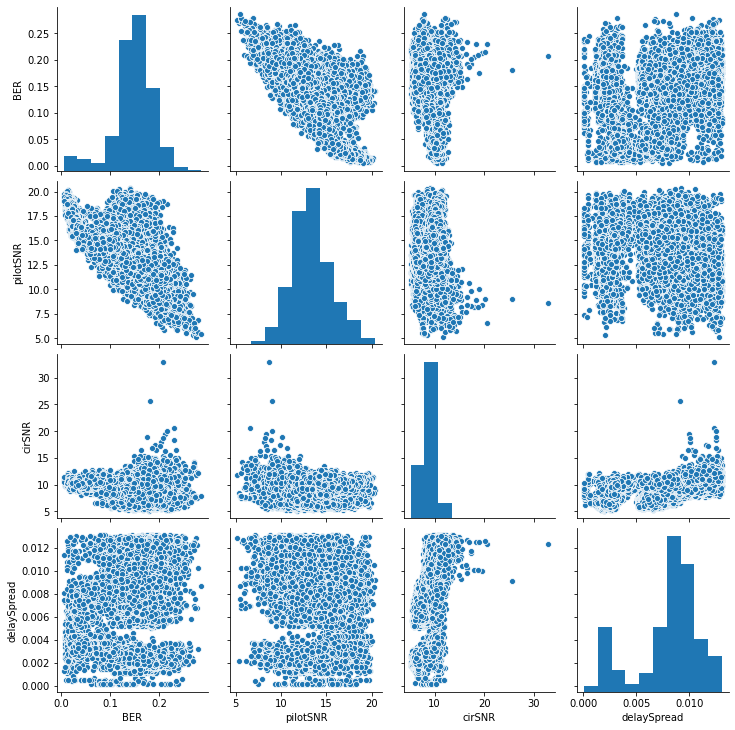

In [ ]:


for ii in dataFiles:
  data = pd.read_csv(os.path.join('./SPACE08/',ii))
  print(ii)
  #sns.pairplot(data)
  print(data.shape)

  
sns.pairplot(data[['BER','pilotSNR','cirSNR','delaySpread']])

Make a variable to store classification results
methods
*   Log Reg
*   NN1
*   NN2
*   KMeans
*   Dummy
*   Decision Rules
*   Decision Tree
*   Bayes

data is stored classifiers x metrics x datsets



In [ ]:
classifierResults = np.zeros([9,4,len(dataFiles)])

Create loop for classifiers

In [ ]:
counter = 0
for ii in dataFiles:

  print(ii)
  data = pd.read_csv(os.path.join('./SPACE08/',ii))
  
  ber = data['BER']

  data = data.drop('BER', axis = 1)

  cols = list(data)

  data = data.dropna()
  #placeholder1 = np.zeros((1,len(data)))
  placeholder1 = (ber <= np.median(ber))*1
  print(np.median(ber))
  #placeholder1 = (data['BER'] <= 0.1)*1
  #placeholder2 = ((data['BER'] > 0.1) & (data['BER'] < 0.2))*2
  #placeholder3 = (data['BER'] >= 0.1)*3
  data['BERClass'] = placeholder1 #+ placeholder2 + placeholder3
  #data['BERClass'] = (data['BER'] <= 0.2)*1
  #data = data.drop('BER',axis=1)
  data = data.dropna()
  #print(placeholder1)

  #print(sum(placeholder3))
  #oversample = SMOTE()
  #xSMOTE, ySMOTE = oversample.fit_resample(data.to_numpy(), data['BERClass'].to_numpy())
  

  #trainX, testX, trainY, testY = train_test_split(xSMOTE, ySMOTE, test_size=0.20)
  trainX, testX, trainY, testY = train_test_split(data[cols].to_numpy(), data['BERClass'].to_numpy(), test_size=0.20)

  #data.plot.hist(y = 'BERClass',bins = len(np.unique(data['BERClass'])),title = ii)
  #plt.figure()
  #n, bins, patches = plt.hist(data['BER'],bins = 10)

  #col = (bins  <= np.median(data['BER']))*1
  #cm = plt.cm.get_cmap('prism')
  #for c,p in zip(col, patches):
  #for jj in range(10):
  #  print(cm(col[jj]))
    #plt.setp(p,'facecolor',cm(c))
 #   plt.setp(patches[jj],'facecolor',cm(col[jj]))
    #print(col[jj])


  #Y,X = np.histogram(ber,10)
  #x_span = X.max() - X.min()
  #reds = [((1.0*(x > np.median(X)))) for x in X]
  #reds = [(1.0*(x > 0.1)) for x in X]

  #C = cm(0.25*(np.asarray(reds)+1))

  #plt.bar(X[:-1],Y,color=C,width=X[1]-X[0])
  #plt.show()



  #Start with logistic regression

  
  clf = LogisticRegression(random_state = 0).fit(trainX,trainY)
  predY = clf.predict(testX)
  
  cmat = confusion_matrix(testY,predY)
  tn,fp,fn,tp = cmat.ravel()
  classifierResults[0,0,counter] = tp/sum(testY)
  classifierResults[0,1,counter] = fp/sum(testY)
  classifierResults[0,2,counter] = precision_score(testY,predY)
  classifierResults[0,3,counter] = recall_score(testY,predY)

  #Neural Net 1 layer
  scaler = StandardScaler()

  scaler.fit(trainX)  
  trainXscaled = scaler.transform(trainX) 

  testXscaled = scaler.transform(testX)



  clf = MLPClassifier(solver = 'sgd',alpha = 1e-4,hidden_layer_sizes = (10,1),random_state = 1, max_iter = 1000)
  clf.fit(trainXscaled,trainY)
  predY = clf.predict(testXscaled)

  cmat = confusion_matrix(testY,predY)
  tn,fp,fn,tp = cmat.ravel()
  classifierResults[1,0,counter] = tp/sum(testY)
  classifierResults[1,1,counter] = fp/sum(testY)
  classifierResults[1,2,counter] = precision_score(testY,predY)
  classifierResults[1,3,counter] = recall_score(testY,predY)

  #Neural Net 2 layer
  clf = MLPClassifier(solver = 'sgd',alpha = 1e-4,hidden_layer_sizes = (10,2),random_state = 1, max_iter = 1000)
  clf.fit(trainXscaled,trainY)
  predY = clf.predict(testXscaled)

  cmat = confusion_matrix(testY,predY)
  tn,fp,fn,tp = cmat.ravel()
  classifierResults[2,0,counter] = tp/sum(testY)
  classifierResults[2,1,counter] = fp/sum(testY)
  classifierResults[2,2,counter] = precision_score(testY,predY)
  classifierResults[2,3,counter] = recall_score(testY,predY)

  

  #k neighbors classifier
  neigh = KNeighborsClassifier(n_neighbors = 9)
  neigh.fit(trainX, trainY)
  predY = neigh.predict(testX)

  cmat = confusion_matrix(testY,predY)
  tn,fp,fn,tp = cmat.ravel()
  classifierResults[3,0,counter] = tp/sum(testY)
  classifierResults[3,1,counter] = fp/sum(testY)
  classifierResults[3,2,counter] = precision_score(testY,predY)
  classifierResults[3,3,counter] = recall_score(testY,predY)


#dummy

  
  dummy_clf = DummyClassifier(strategy = "stratified")
  dummy_clf.fit(trainX,trainY)
  predY = dummy_clf.predict(testX)
  cmat = confusion_matrix(testY,predY)
  tn,fp,fn,tp = cmat.ravel()
  classifierResults[4,0,counter] = tp/sum(testY)
  classifierResults[4,1,counter] = fp/sum(testY)
  classifierResults[4,2,counter] = precision_score(testY,predY)
  classifierResults[4,3,counter] = recall_score(testY,predY)


#ruleset

  rng = np.random.RandomState(123)
  clf = SkopeRules(random_state = rng,n_estimators = 10)
  clf.fit(trainX, trainY)
  predY = clf.predict(testX)

  cmat = confusion_matrix(testY,predY)
  tn,fp,fn,tp = cmat.ravel()
  classifierResults[5,0,counter] = tp/sum(testY)
  classifierResults[5,1,counter] = fp/sum(testY)
  classifierResults[5,2,counter] = precision_score(testY,predY)
  classifierResults[5,3,counter] = recall_score(testY,predY)

# decision tree

  classifier = DecisionTreeClassifier(min_samples_split = 100, min_samples_leaf = 1000)

  classifier.fit(trainX,trainY)
  predY = classifier.predict(testX)

  cmat = confusion_matrix(testY,predY)
  
  tn,fp,fn,tp = cmat.ravel()
  classifierResults[6,0,counter] = tp/sum(testY)
  classifierResults[6,1,counter] = fp/sum(testY)
  classifierResults[6,2,counter] = precision_score(testY,predY)
  classifierResults[6,3,counter] = recall_score(testY,predY)


# bayesnet

  gnb = GaussianNB()
  clf.fit(trainX, trainY)
  predY = clf.predict(testX)

  cmat = confusion_matrix(testY,predY)
  tn,fp,fn,tp = cmat.ravel()
  classifierResults[7,0,counter] = tp/sum(testY)
  classifierResults[7,1,counter] = fp/sum(testY)
  classifierResults[7,2,counter] = precision_score(testY,predY)
  classifierResults[7,3,counter] = recall_score(testY,predY)

#random forest
  clf = RandomForestClassifier(max_depth=35, random_state=0)
  clf.fit(trainX, trainY)
  predY = clf.predict(testX)

  cmat = confusion_matrix(testY,predY)
  tn,fp,fn,tp = cmat.ravel()
  classifierResults[8,0,counter] = tp/sum(testY)
  classifierResults[8,1,counter] = fp/sum(testY)
  classifierResults[8,2,counter] = precision_score(testY,predY)
  classifierResults[8,3,counter] = recall_score(testY,predY)



  counter = counter + 1

qpskDataS6.csv
0.0669642857142857
16qamDataS1.csv
0.39384920634920595
8qamDataS6.csv
0.151785714285714
qpskDataS3.csv
0.0654761904761905
8qamDataS1.csv
0.34598214285714296
8qamDataS5.csv
0.16964285714285698
qpskDataS1.csv
0.30654761904761896


Package the above loop into a function for easier use with modified datasets

In [ ]:
def classifierList(trainX, testX, trainY, testY):

  classifierResults = np.zeros([9,4,1])
  #Start with logistic regression
  counter = 0
  
  clf = LogisticRegression(random_state = 0, max_iter = 200).fit(trainX,trainY)
  predY = clf.predict(testX)
  
  cmat = confusion_matrix(testY,predY)
  tn,fp,fn,tp = cmat.ravel()
  classifierResults[0,0,counter] = tp/sum(testY)
  classifierResults[0,1,counter] = fp/sum(testY)
  classifierResults[0,2,counter] = precision_score(testY,predY)
  classifierResults[0,3,counter] = recall_score(testY,predY)

  #Neural Net 1 layer
  scaler = StandardScaler()

  scaler.fit(trainX)  
  trainXscaled = scaler.transform(trainX) 

  testXscaled = scaler.transform(testX)



  clf = MLPClassifier(solver = 'sgd',alpha = 1e-4,hidden_layer_sizes = (10,1),random_state = 1, max_iter = 2000)
  clf.fit(trainXscaled,trainY)
  predY = clf.predict(testXscaled)

  cmat = confusion_matrix(testY,predY)
  tn,fp,fn,tp = cmat.ravel()
  print(cmat)
  classifierResults[1,0,counter] = tp/sum(testY)
  classifierResults[1,1,counter] = fp/sum(testY)
  classifierResults[1,2,counter] = precision_score(testY,predY)
  classifierResults[1,3,counter] = recall_score(testY,predY)

  #Neural Net 2 layer
  clf = MLPClassifier(solver = 'sgd',alpha = 1e-4,hidden_layer_sizes = (10,2),random_state = 1, max_iter = 2000)
  clf.fit(trainXscaled,trainY)
  predY = clf.predict(testXscaled)

  cmat = confusion_matrix(testY,predY)
  tn,fp,fn,tp = cmat.ravel()
  classifierResults[2,0,counter] = tp/sum(testY)
  classifierResults[2,1,counter] = fp/sum(testY)
  classifierResults[2,2,counter] = precision_score(testY,predY)
  classifierResults[2,3,counter] = recall_score(testY,predY)

  

  #k neighbors classifier
  neigh = KNeighborsClassifier(n_neighbors = 9)
  neigh.fit(trainX, trainY)
  predY = neigh.predict(testX)

  cmat = confusion_matrix(testY,predY)
  tn,fp,fn,tp = cmat.ravel()
  classifierResults[3,0,counter] = tp/sum(testY)
  classifierResults[3,1,counter] = fp/sum(testY)
  classifierResults[3,2,counter] = precision_score(testY,predY)
  classifierResults[3,3,counter] = recall_score(testY,predY)


#dummy

  
  dummy_clf = DummyClassifier(strategy = "stratified")
  dummy_clf.fit(trainX,trainY)
  predY = dummy_clf.predict(testX)
  cmat = confusion_matrix(testY,predY)
  tn,fp,fn,tp = cmat.ravel()
  classifierResults[4,0,counter] = tp/sum(testY)
  classifierResults[4,1,counter] = fp/sum(testY)
  classifierResults[4,2,counter] = precision_score(testY,predY)
  classifierResults[4,3,counter] = recall_score(testY,predY)


#ruleset

  rng = np.random.RandomState(123)
  clf = SkopeRules(random_state = rng,n_estimators = 10)
  clf.fit(trainX, trainY)
  predY = clf.predict(testX)

  cmat = confusion_matrix(testY,predY)
  tn,fp,fn,tp = cmat.ravel()
  classifierResults[5,0,counter] = tp/sum(testY)
  classifierResults[5,1,counter] = fp/sum(testY)
  classifierResults[5,2,counter] = precision_score(testY,predY)
  classifierResults[5,3,counter] = recall_score(testY,predY)

# decision tree

  classifier = DecisionTreeClassifier(min_samples_split = 100, min_samples_leaf = 1000)

  classifier.fit(trainX,trainY)
  predY = classifier.predict(testX)

  cmat = confusion_matrix(testY,predY)
  
  tn,fp,fn,tp = cmat.ravel()
  classifierResults[6,0,counter] = tp/sum(testY)
  classifierResults[6,1,counter] = fp/sum(testY)
  classifierResults[6,2,counter] = precision_score(testY,predY)
  classifierResults[6,3,counter] = recall_score(testY,predY)


# bayesnet

  gnb = GaussianNB()
  clf.fit(trainX, trainY)
  predY = clf.predict(testX)

  cmat = confusion_matrix(testY,predY)
  tn,fp,fn,tp = cmat.ravel()
  classifierResults[7,0,counter] = tp/sum(testY)
  classifierResults[7,1,counter] = fp/sum(testY)
  classifierResults[7,2,counter] = precision_score(testY,predY)
  classifierResults[7,3,counter] = recall_score(testY,predY)

#random forest
  clf = RandomForestClassifier(max_depth=35, random_state=0)
  clf.fit(trainX, trainY)
  predY = clf.predict(testX)

  cmat = confusion_matrix(testY,predY)
  tn,fp,fn,tp = cmat.ravel()
  classifierResults[8,0,counter] = tp/sum(testY)
  classifierResults[8,1,counter] = fp/sum(testY)
  classifierResults[8,2,counter] = precision_score(testY,predY)
  classifierResults[8,3,counter] = recall_score(testY,predY)

  return classifierResults


# Apply SMOTE to KWAUG14 dataset and run classifer function with and without SMOTE

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

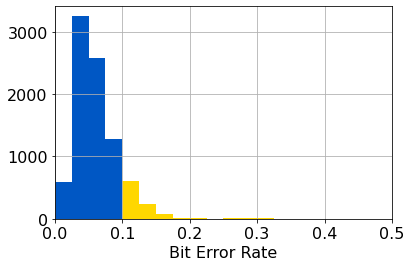

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

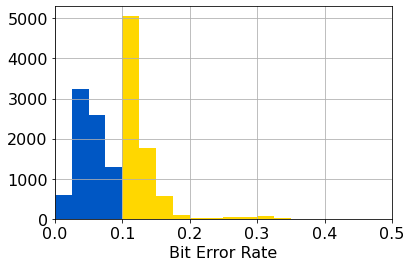

[[   0  196]
 [   0 1536]]
[[1512    0]
 [1565    0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:

plt.rcParams.update({'font.size':16})

filename = 'KWAUG14data.csv'
data = pd.read_csv(os.path.join('./SPACE08/',filename))

cm = plt.cm.get_cmap('prism')

ber = data['BER'].to_numpy()
Y,X = np.histogram(ber, bins = [0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4, 0.425, 0.45, 0.475, 0.5])
#fig0 = data.hist(column = 'BER')
reds = [(1.0*(x > 0.099)) for x in X]

C = cm(0.25*(np.asarray(reds)+1))


fig0= plt.subplot()

plt.bar(X[:-1],Y,color=C,align = 'edge',width=X[1]-X[0])
plt.xlim(0,0.5)
plt.xlabel('Bit Error Rate')
plt.title('')
plt.grid(True)




plt.tight_layout()



plt.savefig('KW14hist.png')
files.download('KW14hist.png')
plt.show()




cols = list(data)

data = data.dropna()

BERClass = (data['BER'] <= 0.1)*1






#featureMat = np.asarray(data.values['pilotSNR','recSNR','RMSDS','BER'])

oversample = SMOTE()
xSMOTE, ySMOTE = oversample.fit_resample(data, BERClass)

fig1 = plt.subplot()
ber = xSMOTE[:,-1]

Y,X = np.histogram(ber, bins = [0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4, 0.425, 0.45, 0.475, 0.5])
#fig0 = data.hist(column = 'BER')
reds = [(1.0*(x > 0.099)) for x in X]

C = cm(0.25*(np.asarray(reds)+1))

plt.bar(X[:-1],Y,color=C,align = 'edge',width=X[1]-X[0])


plt.xlim(0,0.5)
plt.xlabel('Bit Error Rate')
plt.grid(True)


plt.tight_layout()

plt.savefig('KW14histSMOTE.png')
files.download('KW14histSMOTE.png')
plt.show()


data = data.drop('BER',axis=1)


trainX, testX, trainY, testY = train_test_split(data.to_numpy(), BERClass, test_size=0.20)
origResults = classifierList(trainX, testX, trainY, testY)



xSMOTE = np.delete(xSMOTE,-1,1)

trainX, testX, trainY, testY  = train_test_split(xSMOTE, ySMOTE, test_size=0.20)
smoteResults = classifierList(trainX, testX, trainY, testY)

Define some useful functions for regression and processing data





In [ ]:
def rmseCalcNorm(tMeas, tPred):
    rmse = np.sqrt(np.mean(np.square(tMeas - tPred), axis=0))/np.mean(tMeas)
    return rmse

In [ ]:
def mseCalc(tMeas, tPred):
    mse = np.mean(np.square(tMeas - tPred), axis=0)
    return mse

In [ ]:
def mapeCalc(tMeas, tPred):
    mape = np.mean(np.abs((tPred - tMeas)/(tPred+tMeas)/2), axis = 0)
    return mape

In [ ]:
def findFileIndex(name):

  ii = 0
  length = len(dataFiles)
  index = [];

  while ii < length:

    if name == dataFiles[ii]:
      index = ii;
    ii += 1
  return index

In [ ]:
def addBiasTerm(x):
    y = np.insert(x, 0, 1, axis=1)
    return y

In [ ]:
def linregression(feature_matrix, output_matrix):
    weight_matrix = np.matmul(np.matmul(np.linalg.pinv(np.matmul(feature_matrix.T,feature_matrix)),\
                                        feature_matrix.T),output_matrix)
    return weight_matrix

In [ ]:
def linregressionRegularized(feature_matrix, output_matrix, lam):
    weight_matrix = np.matmul(
        np.linalg.pinv(
            np.matmul(feature_matrix, feature_matrix.T) +
            lam * np.eye(len(feature_matrix))), feature_matrix)
    weight_matrix = np.matmul(weight_matrix.T, output_matrix)
    return weight_matrix

In [ ]:
def linregressionPolynomial(feature_matrix, output_matrix, ldegree, llam):
    poly = PolynomialFeatures(degree=ldegree)
    poly_feature = poly.fit_transform(feature_matrix)
    weight_matrix = linregressionRegularized(poly_feature, output_matrix, llam)

    lmse = mseCalc(np.matmul(poly_feature, weight_matrix), output_matrix)

    return weight_matrix, lmse

In [ ]:
def my_regression_1D(trainX, testX, numOfOutputs):

 
    #Create Folds - Split data into '5' folds
    nfolds = 5

    #number of samples provided for training
    ntrain = trainX.shape[0]
    indices = np.linspace(0, ntrain, nfolds + 1, dtype=int)

    degree = [2, 3]
    lamd = [0.01, 0.1, 1]

    errordata2 = np.zeros((len(indices) - 1, len(degree), len(lamd)))
    xaverage = np.zeros((len(lamd), len(degree)))

    for ii in range(len(indices) - 1):
        test_data = trainX[indices[ii]:indices[ii + 1]]
        train_data = trainX
        train_data = np.delete(train_data, np.s_[indices[ii]:indices[ii + 1]],0)

        #Taking feature matrix and output matrix from different folds
        train_data_ftr = train_data[:, :-numOfOutputs]
        train_data_ftr = addBiasTerm(train_data_ftr)

        train_data_out = train_data[:, -numOfOutputs]

        #Taking Feature Matrix and output matrix from test data
        test_data_ftr = test_data[:, :-numOfOutputs]
        test_data_ftr = addBiasTerm(test_data_ftr)

        test_data_out = test_data[:, -numOfOutputs]

        #polynomial fit of the feature matrix and test matrix
        errordata = []

        for iii in range(len(degree)):
            i = degree[iii]
            polyftr = PolynomialFeatures(degree=i)
            polyfit_ftr_matrix = polyftr.fit_transform(train_data_ftr)
            polyfit_testftr_matrix = polyftr.fit_transform(test_data_ftr)
            for jjj in range(len(lamd)):
                j = lamd[jjj]
                weight_matrix = linregressionRegularized(
                    polyfit_ftr_matrix, train_data_out, j)
                test_predicted = np.matmul(polyfit_testftr_matrix,
                                           weight_matrix)
                error = mseCalc(test_data_out, test_predicted)
                errordata.append([ii, i, j, error])
                errordata2[ii, iii, jjj] = error

        df = pd.DataFrame(columns=["Fold", "Degree", "lambda", "error"],
                          data=errordata)

        #print(df)
            
    xaverage = np.mean(errordata2,axis=0)
    
    p = np.unravel_index(xaverage.argmin(), xaverage.shape)

    print("Minimum MSE is at degree = {} and lambda = {}".format(degree[p[0]], lamd[p[1]]))

    #now let's train entire data with degree (degree[p[0]]) and lambda (lamd[p[1]]) found in CV
    train_feature_matrix = addBiasTerm(trainX[:, :-numOfOutputs])
    train_output_matrix = trainX[:, -numOfOutputs]

    polyftr = PolynomialFeatures(degree=degree[p[0]])
    polyfit_ftr_matrix = polyftr.fit_transform(train_feature_matrix)
    weight_matrix = linregressionRegularized(polyfit_ftr_matrix, train_output_matrix, lamd[p[1]])
    test_predicted = np.matmul(polyfit_ftr_matrix, weight_matrix)
    xmse = mseCalc(train_output_matrix, test_predicted)
    
    polyftr = PolynomialFeatures(degree=degree[p[0]])
    polyfit_ftr_matrix = polyftr.fit_transform(addBiasTerm(testX[:, :-numOfOutputs]))
    test_predicted = np.matmul(polyfit_ftr_matrix, weight_matrix)

    return test_predicted, weight_matrix

In [ ]:
def my_regressionRBF(trainX, testX, numOfOutputs):

    #Create Folds - Split data into '5' folds
    nfolds = 5

    #number of samples provided for training
    ntrain = trainX.shape[0]
    indices = np.linspace(0, ntrain, nfolds + 1, dtype=int)

    nBasis = [20,30,50,80]
    sigmaSize = [.01,.05,.1,.5,1]
    errordata2 = np.zeros((len(indices) - 1, len(nBasis), len(sigmaSize)))

    xaverage = np.zeros((len(nBasis), len(sigmaSize)))

    for ii in range(len(indices) - 1):
        test_data = trainX[indices[ii]:indices[ii + 1]]
        train_data = trainX
        train_data = np.delete(train_data, np.s_[indices[ii]:indices[ii + 1]],0)

        #Taking feature matrix and output matrix from different folds
        train_data_ftr = train_data[:, :-numOfOutputs]
        train_data_out = train_data[:, -numOfOutputs:]

        #Taking Feature Matrix and output matrix from test data
        test_data_ftr = test_data[:, :-numOfOutputs]
        test_data_out = test_data[:, -numOfOutputs:]
        errordata = []

        for iii in range(len(nBasis)):
            for jjj in range(len(sigmaSize)):
                rbfFeature = RBFSampler(gamma=sigmaSize[jjj],n_components=nBasis[iii],random_state=666)        
                polyfit_ftr_matrix = rbfFeature.fit_transform(train_data_ftr)
                polyfit_testftr_matrix = rbfFeature.transform(test_data_ftr)
                #print(iii)
                #print(jjj)
                #print(ii)
                weight_matrix = linregression(polyfit_ftr_matrix, train_data_out)
                test_predicted = np.matmul(polyfit_testftr_matrix, weight_matrix)
                error = mseCalc(test_data_out, test_predicted)
                errordata2[ii, iii, jjj] = error
                
                
        df = pd.DataFrame(columns=["Fold", "Degree", "lambda", "error"],
                          data=errordata)
        
        #print(df)
            
    xaverage = np.mean(errordata2,axis=0)

    p = np.unravel_index(xaverage.argmin(), xaverage.shape)

    print("Minimum MSE is at nRBF = {} and gamma = {}".format(
        nBasis[p[1]], sigmaSize[p[0]]))

    #now let's train entire data with degree (degree[p[0]]) and lambda (lamd[p[1]]) found in CV
    train_feature_matrix = trainX[:, :-numOfOutputs]
    train_output_matrix = trainX[:, -numOfOutputs:]

    print(p)    
    rbfFeature = RBFSampler(gamma=sigmaSize[p[1]],n_components=nBasis[p[0]],random_state=666)
    polyfit_ftr_matrix = rbfFeature.fit_transform(train_feature_matrix)
    polyfit_testftr_matrix = rbfFeature.fit_transform(testX[:, :-numOfOutputs])
    weight_matrix = linregression(polyfit_ftr_matrix, train_output_matrix)


    test_predicted = np.matmul(polyfit_testftr_matrix, weight_matrix)

    return test_predicted, weight_matrix

Loop through different regressions and store the results
Regression methods:


1.   Linear regression
2.   linear regression with RBF transformation
3.   Neural net with 1 layer
4.   neural net with 2 layer
5.   KNN
6.   Dummy/ZeroR
7.   Decision tree




In [ ]:
regressionResults = np.zeros([7,3,len(dataFiles)])

In [ ]:

counter = 0



for ii in dataFiles:


  #linear regression
  print(ii)
  data = pd.read_csv(os.path.join('./SPACE08/',ii))
  cols = data.columns.tolist()

  data = data[cols]
  data = data.dropna()
  trainX, testX = train_test_split(data,test_size = 0.2)

  regr = LinearRegression().fit(trainX[cols[:-1]],trainX[cols[-1]])
  pred = regr.predict(testX[cols[:-1]])
  error = rmseCalcNorm(np.asarray(testX['BER']), np.squeeze(pred))
  
  regressionResults[0,0,counter] = error
  regressionResults[0,1,counter] = mapeCalc(np.asarray(testX['BER']), np.squeeze(pred))
  pearsoncoeff = pearsonr(np.asarray(testX['BER']), np.squeeze(pred))
  regressionResults[0,2,counter]  = pearsoncoeff[0]

  #print('Mean Squared Error for this regression is',error)

  #RBF approx lin regression
  pred, weights = my_regressionRBF(np.asarray(trainX), np.asarray(testX), 1)
  #print(weights)
  error = rmseCalcNorm(np.asarray(testX['BER']), np.squeeze(pred))
  #print('Mean Squared Error for this regression is',error)

  regressionResults[1,0,counter] = error
  regressionResults[1,1,counter] = mapeCalc(np.asarray(testX['BER']), np.squeeze(pred))
  pearsoncoeff = pearsonr(np.asarray(testX['BER']), np.squeeze(pred))
  regressionResults[1,2,counter]  = pearsoncoeff[0]


  #NN 1 layer

  regr = MLPRegressor(hidden_layer_sizes = (10,), random_state = 1,max_iter = 1000).fit(trainX[cols[:-1]],trainX[cols[-1]])
  pred = regr.predict(testX[cols[:-1]])
  error = rmseCalcNorm(np.asarray(testX['BER']), np.squeeze(pred))
  regressionResults[2,0,counter] = error

  print('Mean Squared Error for NN1 is',error)
  regressionResults[2,1,counter] = mapeCalc(np.asarray(testX['BER']), np.squeeze(pred))
  pearsoncoeff = pearsonr(np.asarray(testX['BER']), np.squeeze(pred))
  regressionResults[2,2,counter]  = pearsoncoeff[0]




  #NN 2 layer
  regr = MLPRegressor(hidden_layer_sizes = (10,10), random_state = 1,max_iter = 1000).fit(trainX[cols[:-1]],trainX[cols[-1]])
  pred = regr.predict(testX[cols[:-1]])
  error = rmseCalcNorm(np.asarray(testX['BER']), np.squeeze(pred))
  print('Mean Squared Error for NN2 is',error)


  regressionResults[3,0,counter] = error
  regressionResults[3,1,counter] = mapeCalc(np.asarray(testX['BER']), np.squeeze(pred))
  pearsoncoeff = pearsonr(np.asarray(testX['BER']), np.squeeze(pred))
  regressionResults[3,2,counter]  = pearsoncoeff[0]


  #KNN
  neigh = KNeighborsRegressor(n_neighbors = 9).fit(trainX[cols[:-1]],trainX[cols[-1]])
  pred = neigh.predict(testX[cols[:-1]])
  error = rmseCalcNorm(np.asarray(testX['BER']), np.squeeze(pred))
  regressionResults[4,0,counter] = error
  regressionResults[4,1,counter] = mapeCalc(np.asarray(testX['BER']), np.squeeze(pred))
  pearsoncoeff = pearsonr(np.asarray(testX['BER']), np.squeeze(pred))
  regressionResults[4,2,counter]  = pearsoncoeff[0]

  #Dummy
  dummy_regr = DummyRegressor(strategy = "median")
  dummy_regr.fit(trainX[cols[:-1]],trainX[cols[-1]])
  pred = dummy_regr.predict(testX[cols[:-1]])

  error = rmseCalcNorm(np.asarray(testX['BER']), np.squeeze(pred))
  
  regressionResults[5,0,counter] = error
  regressionResults[5,1,counter] = mapeCalc(np.asarray(testX['BER']), np.squeeze(pred))
  pearsoncoeff = pearsonr(np.asarray(testX['BER']), np.squeeze(pred))
  regressionResults[5,2,counter]  = pearsoncoeff[0]



  #Decision tree

  regr = DecisionTreeRegressor(random_state = 0)
  regr.fit(trainX[cols[:-1]],trainX[cols[-1]])
  pred = regr.predict(testX[cols[:-1]])

  error = rmseCalcNorm(np.asarray(testX['BER']), np.squeeze(pred))

  regressionResults[6,0,counter] = error
  regressionResults[6,1,counter] = mapeCalc(np.asarray(testX['BER']), np.squeeze(pred))
  pearsoncoeff = pearsonr(np.asarray(testX['BER']), np.squeeze(pred))
  regressionResults[6,2,counter]  = pearsoncoeff[0]





  counter = counter + 1


qpskDataS6.csv
Minimum MSE is at nRBF = 20 and gamma = 0.5
(3, 0)
Mean Squared Error for NN1 is 0.7160441108729426
Mean Squared Error for NN2 is 0.6143181015228764


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


16qamDataS1.csv
Minimum MSE is at nRBF = 50 and gamma = 0.05
(1, 2)
Mean Squared Error for NN1 is 0.11712850326813924
Mean Squared Error for NN2 is 0.1167130511302411


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


8qamDataS6.csv
Minimum MSE is at nRBF = 30 and gamma = 0.5
(3, 1)
Mean Squared Error for NN1 is 0.27763673086813045
Mean Squared Error for NN2 is 0.2579646908933211


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


qpskDataS3.csv
Minimum MSE is at nRBF = 20 and gamma = 0.5
(3, 0)
Mean Squared Error for NN1 is 0.7118070936123048
Mean Squared Error for NN2 is 0.7160229903814948


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


8qamDataS1.csv
Minimum MSE is at nRBF = 20 and gamma = 0.05
(1, 0)
Mean Squared Error for NN1 is 0.2007907090826255
Mean Squared Error for NN2 is 0.19955018813613515


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


8qamDataS5.csv
Minimum MSE is at nRBF = 30 and gamma = 0.5
(3, 1)
Mean Squared Error for NN1 is 0.17685240109351172
Mean Squared Error for NN2 is 0.18040773302023166


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


qpskDataS1.csv
Minimum MSE is at nRBF = 50 and gamma = 0.05
(1, 2)
Mean Squared Error for NN1 is 0.3470724572719484
Mean Squared Error for NN2 is 0.34644970447067797


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


16qamDataS2.csv
Minimum MSE is at nRBF = 20 and gamma = 0.1
(2, 0)
Mean Squared Error for NN1 is 0.09862439595828745
Mean Squared Error for NN2 is 0.09758039790876753


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


KWAUG14data.csv
Minimum MSE is at nRBF = 30 and gamma = 0.5
(3, 1)
Mean Squared Error for NN1 is 1.187275365806362
Mean Squared Error for NN2 is 0.4325101224536437
qpskDataS4.csv


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Minimum MSE is at nRBF = 50 and gamma = 0.05
(1, 2)
Mean Squared Error for NN1 is 0.31126407352395186
Mean Squared Error for NN2 is 0.3057199295772131


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


8qamDataS2.csv
Minimum MSE is at nRBF = 50 and gamma = 0.05
(1, 2)
Mean Squared Error for NN1 is 0.14927182447441895
Mean Squared Error for NN2 is 0.14992236851259994


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


16qamDataS3.csv
Minimum MSE is at nRBF = 30 and gamma = 0.1
(2, 1)
Mean Squared Error for NN1 is 0.12915883884463222
Mean Squared Error for NN2 is 0.12374999541579232


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


8qamDataS4.csv
Minimum MSE is at nRBF = 50 and gamma = 0.05
(1, 2)
Mean Squared Error for NN1 is 0.21532847412402045
Mean Squared Error for NN2 is 0.1749935691800917


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


qpskDataS5.csv
Minimum MSE is at nRBF = 20 and gamma = 0.1
(2, 0)
Mean Squared Error for NN1 is 0.3357484160078187
Mean Squared Error for NN2 is 0.3339069157345617


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


16qamDataS4.csv
Minimum MSE is at nRBF = 30 and gamma = 0.05
(1, 1)
Mean Squared Error for NN1 is 0.09818554104311956
Mean Squared Error for NN2 is 0.10203249199208517


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


qpskDataS2.csv
Minimum MSE is at nRBF = 50 and gamma = 0.1
(2, 2)
Mean Squared Error for NN1 is 0.2963755881636007
Mean Squared Error for NN2 is 0.2867285986662025


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


8qamDataS3.csv
Minimum MSE is at nRBF = 20 and gamma = 0.01
(0, 0)
Mean Squared Error for NN1 is 0.18561741295266135
Mean Squared Error for NN2 is 0.20060720432556786


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


16qamDataS5.csv
Minimum MSE is at nRBF = 50 and gamma = 0.5
(3, 2)
Mean Squared Error for NN1 is 0.130916929002612
Mean Squared Error for NN2 is 0.11981787659196662


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


16qamDataS6.csv
Minimum MSE is at nRBF = 80 and gamma = 0.5
(3, 3)
Mean Squared Error for NN1 is 0.13617189641347505
Mean Squared Error for NN2 is 0.12010195340131084


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Export regression results for viewing elsewhere

In [ ]:
counter = 0

with pd.ExcelWriter('regressionResults.xlsx') as writer:
  for ii in dataFiles:
    d = {'model':['Lin. Reg','RBF lin reg','Neural Net 1 layer','Neural Net 2 layer','KNearest Neighbor','ZeroR','Dec tree'],'mean squared error':[Lmse[counter],Rmse[counter],N1mse[counter],N2mse[counter],Kmse[counter],Zmse[counter],Dmse[counter]],'mean abs error':[LmeanAbsError[counter],RmeanAbsError[counter],N1meanAbsError[counter],N2meanAbsError[counter],KmeanAbsError[counter],ZmeanAbsError[counter],DmeanAbsError[counter]],'Pearson correlation coefficient':[LcorrCoeff[counter],RcorrCoeff[counter],N1corrCoeff[counter],N2corrCoeff[counter],KcorrCoeff[counter],ZcorrCoeff[counter],DcorrCoeff[counter]]}
    df = pd.DataFrame(d)
  

    df.to_excel(writer, sheet_name = ii)
  
    counter = counter + 1

writer.save()
files.download('regressionResults.xlsx')

Make figure of regression results


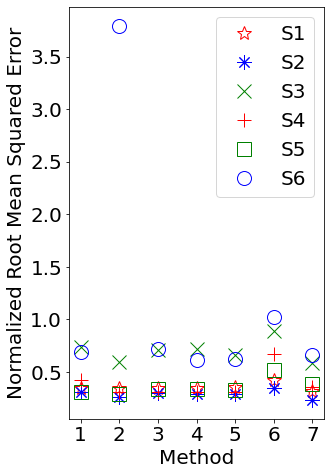

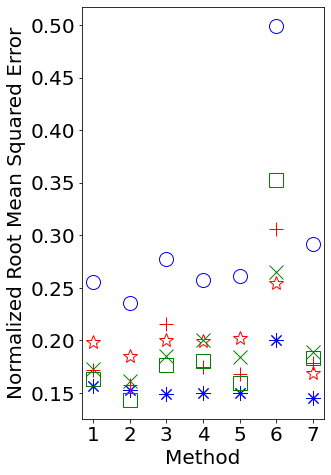

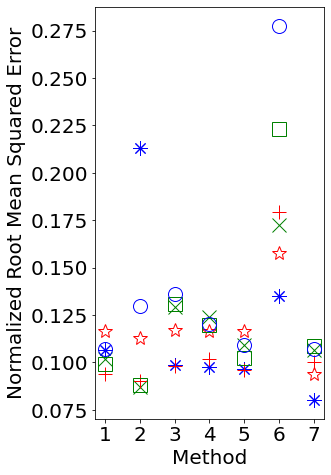

In [ ]:
plt.rcParams.update({'font.size':20})

modelNames = ['Lin. Reg','RBF lin reg','Neural Net 1 layer','Neural Net 2 layer','KNearest Neighbor','ZeroR','Dec. tree']


mods = ['qpsk','8qam','16qam']
markerS = ['*',(8,2,0),'x','+','s','o']
colorS = ['r','b','g','r','g','b']

plotMat = np.zeros([7,6,3])
for s in range(6):
  for m in range(3):
    filename = mods[m]+'DataS'+str(s+1)+'.csv'
    counter = findFileIndex(filename)
    #print( regressionResults[:,0,counter])
    plotMat[:,s,m] = regressionResults[:,0,counter]

#for m in range(3):
  
  
m = 0  
d = {'Model':['Lin Reg','RBF Lin Reg','Neural Net 1 Layer','Neural Net 2 Layer','K Nearest Neighbor','ZeroR','Dec Tree'],'S1':plotMat[:,0,m],'S2':plotMat[:,1,m],'S3':plotMat[:,2,m],'S4':plotMat[:,3,m],'S5':plotMat[:,4,m],'S6':plotMat[:,5,m]}
fig0, ax = plt.subplots(figsize = (5,7))    
df = pd.DataFrame(d)
for s in range(6):

  g = df.plot(x = 'Model',y = ('S'+str(s+1)),ax = ax,legend=False,marker = markerS[s],color = colorS[s],fillstyle = 'none',linestyle = 'none',ms = 14)
    
    

#axes[0].set_title('QPSK')
#axes[1].set_title('8-QAM')
#axes[2].set_title('16-QAM')

ax.set_xticklabels([1,2,3,4,5,6,7], rotation=0)
ax.set_xticks([0,1,2,3,4,5,6])
#axes[1].set_xticklabels([1,2,3,4,5,6,7], rotation=0)
#axes[2].set_xticklabels([1,2,3,4,5,6,7], rotation=0)



ax.set_xlabel('Method')
ax.set_ylabel('Normalized Root Mean Squared Error')
ax.legend(['S1','S2','S3','S4','S5','S6'])
fig0.tight_layout()

plt.show()
fig0.savefig('regressionNRMSEqpsk.png')


fig1, ax = plt.subplots(figsize = (5,7))
m = 1  
d = {'Model':['Lin Reg','RBF Lin Reg','Neural Net 1 Layer','Neural Net 2 Layer','K Nearest Neighbor','ZeroR','Dec Tree'],'S1':plotMat[:,0,m],'S2':plotMat[:,1,m],'S3':plotMat[:,2,m],'S4':plotMat[:,3,m],'S5':plotMat[:,4,m],'S6':plotMat[:,5,m]}
    
df = pd.DataFrame(d)
for s in range(6):

  g = df.plot(x = 'Model',y = ('S'+str(s+1)),ax = ax,legend=False,marker = markerS[s],color = colorS[s],fillstyle = 'none',linestyle = 'none',ms=14)
    
    

#axes[0].set_title('QPSK')
#axes[1].set_title('8-QAM')
#axes[2].set_title('16-QAM')

ax.set_xticklabels([1,2,3,4,5,6,7], rotation=0)
ax.set_xticks([0,1,2,3,4,5,6])
#axes[1].set_xticklabels([1,2,3,4,5,6,7], rotation=0)
#axes[2].set_xticklabels([1,2,3,4,5,6,7], rotation=0)

#plt.rcParams.update({'font.size':12})

ax.set_xlabel('Method')
ax.set_ylabel('Normalized Root Mean Squared Error')
#ax.legend(['S1','S2','S3','S4','S5','S6'])

fig1.tight_layout()
plt.show()
fig1.savefig('regressionNRMSE8qam.png')







fig2, ax = plt.subplots(figsize = (5,7))
m = 2  
d = {'Model':['Lin Reg','RBF Lin Reg','Neural Net 1 Layer','Neural Net 2 Layer','K Nearest Neighbor','ZeroR','Dec Tree'],'S1':plotMat[:,0,m],'S2':plotMat[:,1,m],'S3':plotMat[:,2,m],'S4':plotMat[:,3,m],'S5':plotMat[:,4,m],'S6':plotMat[:,5,m]}
    
df = pd.DataFrame(d)
for s in range(6):

  g = df.plot(x = 'Model',y = ('S'+str(s+1)),ax = ax,legend=False,marker = markerS[s],color = colorS[s],fillstyle = 'none',linestyle = 'none',ms=14)
    
    

#axes[0].set_title('QPSK')
#axes[1].set_title('8-QAM')
#axes[2].set_title('16-QAM')

ax.set_xticklabels([1,2,3,4,5,6,7], rotation=0)
ax.set_xticks([0,1,2,3,4,5,6])
#axes[1].set_xticklabels([1,2,3,4,5,6,7], rotation=0)
#axes[2].set_xticklabels([1,2,3,4,5,6,7], rotation=0)

#plt.rcParams.update({'font.size':12})

ax.set_xlabel('Method')
ax.set_ylabel('Normalized Root Mean Squared Error')
#ax.legend(['S1','S2','S3','S4','S5','S6'])

fig2.tight_layout()
plt.show()
fig2.savefig('regressionNRMSE16qam.png')


Download figures

In [ ]:

files.download('regressionNRMSE16qam.png')
files.download('regressionNRMSE8qam.png')
files.download('regressionNRMSEqpsk.png')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

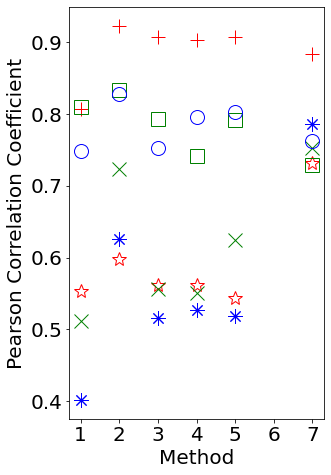

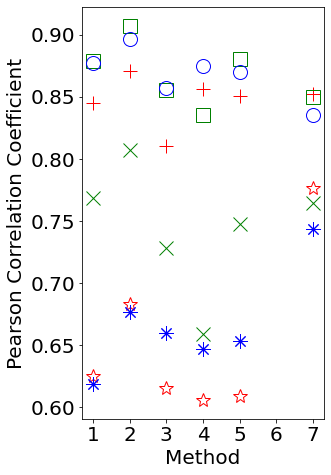

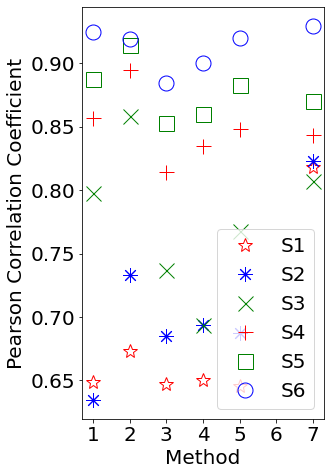

In [ ]:
plt.rcParams.update({'font.size':20})

modelNames = ['Lin. Reg','RBF lin reg','Neural Net 1 layer','Neural Net 2 layer','KNearest Neighbor','ZeroR','Dec. tree']


mods = ['qpsk','8qam','16qam']
markerS = ['*',(8,2,0),'x','+','s','o']
colorS = ['r','b','g','r','g','b']

plotMat = np.zeros([7,6,3])
for s in range(6):
  for m in range(3):
    filename = mods[m]+'DataS'+str(s+1)+'.csv'
    counter = findFileIndex(filename)
    #print( regressionResults[:,0,counter])
    plotMat[:,s,m] = regressionResults[:,2,counter]

#for m in range(3):
  
  
m = 0  
d = {'Model':['Lin Reg','RBF Lin Reg','Neural Net 1 Layer','Neural Net 2 Layer','K Nearest Neighbor','ZeroR','Dec Tree'],'S1':plotMat[:,0,m],'S2':plotMat[:,1,m],'S3':plotMat[:,2,m],'S4':plotMat[:,3,m],'S5':plotMat[:,4,m],'S6':plotMat[:,5,m]}
fig0, ax = plt.subplots(figsize = (5,7))    
df = pd.DataFrame(d)
for s in range(6):

  g = df.plot(x = 'Model',y = ('S'+str(s+1)),ax = ax,legend=False,marker = markerS[s],color = colorS[s],fillstyle = 'none',linestyle = 'none',ms=14)
    
    

#axes[0].set_title('QPSK')
#axes[1].set_title('8-QAM')
#axes[2].set_title('16-QAM')

ax.set_xticklabels([1,2,3,4,5,6,7], rotation=0)
ax.set_xticks([0,1,2,3,4,5,6])
#axes[1].set_xticklabels([1,2,3,4,5,6,7], rotation=0)
#axes[2].set_xticklabels([1,2,3,4,5,6,7], rotation=0)


ax.set_xlabel('Method')
ax.set_ylabel('Pearson Correlation Coefficient')

#ax.legend(['S1','S2','S3','S4','S5','S6'])
fig0.tight_layout()

plt.show()
fig0.savefig('regressionCorrqpsk.png')


fig1, ax = plt.subplots(figsize = (5,7))
m = 1  
d = {'Model':['Lin Reg','RBF Lin Reg','Neural Net 1 Layer','Neural Net 2 Layer','K Nearest Neighbor','ZeroR','Dec Tree'],'S1':plotMat[:,0,m],'S2':plotMat[:,1,m],'S3':plotMat[:,2,m],'S4':plotMat[:,3,m],'S5':plotMat[:,4,m],'S6':plotMat[:,5,m]}
    
df = pd.DataFrame(d)
for s in range(6):

  g = df.plot(x = 'Model',y = ('S'+str(s+1)),ax = ax,legend=False,marker = markerS[s],color = colorS[s],fillstyle = 'none',linestyle = 'none',ms=14)
    
    

#axes[0].set_title('QPSK')
#axes[1].set_title('8-QAM')
#axes[2].set_title('16-QAM')

ax.set_xticklabels([1,2,3,4,5,6,7], rotation=0)
ax.set_xticks([0,1,2,3,4,5,6])
#axes[1].set_xticklabels([1,2,3,4,5,6,7], rotation=0)
#axes[2].set_xticklabels([1,2,3,4,5,6,7], rotation=0)


ax.set_xlabel('Method')
ax.set_ylabel('Pearson Correlation Coefficient')

#ax.legend(['S1','S2','S3','S4','S5','S6'])
fig1.tight_layout()

plt.show()
fig1.savefig('regressionCorr8qam.png')







fig2, ax = plt.subplots(figsize = (5,7))
m = 2  
d = {'Model':['Lin Reg','RBF Lin Reg','Neural Net 1 Layer','Neural Net 2 Layer','K Nearest Neighbor','ZeroR','Dec Tree'],'S1':plotMat[:,0,m],'S2':plotMat[:,1,m],'S3':plotMat[:,2,m],'S4':plotMat[:,3,m],'S5':plotMat[:,4,m],'S6':plotMat[:,5,m]}
    
df = pd.DataFrame(d)
for s in range(6):

  g = df.plot(x = 'Model',y = ('S'+str(s+1)),ax = ax,legend=False,marker = markerS[s],color = colorS[s],fillstyle = 'none',linestyle = 'none',ms=15)
    
    

#axes[0].set_title('QPSK')
#axes[1].set_title('8-QAM')
#axes[2].set_title('16-QAM')

ax.set_xticklabels([1,2,3,4,5,6,7], rotation=0)
ax.set_xticks([0,1,2,3,4,5,6])
#axes[1].set_xticklabels([1,2,3,4,5,6,7], rotation=0)
#axes[2].set_xticklabels([1,2,3,4,5,6,7], rotation=0)


ax.set_xlabel('Method')
ax.set_ylabel('Pearson Correlation Coefficient')

#ax.legend(['S1','S2','S3','S4','S5','S6'])
fig2.tight_layout()

plt.show()
fig2.savefig('regressionCorr16qam.png')

In [ ]:
files.download('regressionCorr16qam.png')
files.download('regressionCorr8qam.png')
files.download('regressionCorrqpsk.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

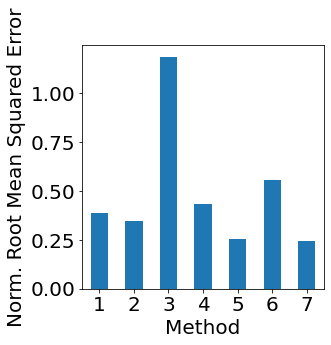

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

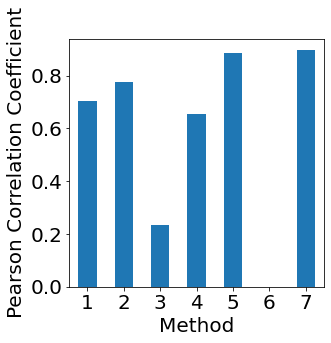

In [ ]:

fig, ax = plt.subplots(figsize = (5,5))

filename = 'KWAUG14data.csv'
counter = findFileIndex(filename)
d = {'Method':['1','2','3','4','5','6','7'],'Mean Squared Error':regressionResults[:,0,counter],'Pearson Correlation Coefficient':regressionResults[:,2,counter]}
df = pd.DataFrame(d)
  
#df.plot.bar(x = 'Model',y = 'Mean Squared Error')  
df.plot.bar(x = 'Method',y = 'Mean Squared Error', ax = ax,legend=False)


ax.set_xticklabels([1,2,3,4,5,6,7], rotation=0)

ax.set_ylabel('Norm. Root Mean Squared Error')

fig.tight_layout()
plt.savefig('KW14regRMSE.png')
files.download('KW14regRMSE.png')

plt.show()


fig, ax = plt.subplots(figsize = (5,5))


#df.plot.bar(x = 'Model',y = 'Mean Squared Error')  

df.plot.bar(x = 'Method',y = 'Pearson Correlation Coefficient', ax = ax,legend=False)

ax.set_ylabel('Pearson Correlation Coefficient')
ax.set_xticklabels([1,2,3,4,5,6,7], rotation=0)


fig.tight_layout()
plt.savefig('KW14regcorr.png')
files.download('KW14regcorr.png')

plt.show()

Make a plot of channel paramter evolution

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<function matplotlib.pyplot.show>

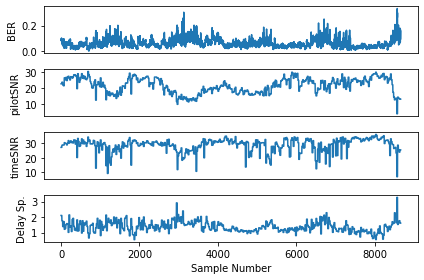

In [ ]:

filename = 'KWAUG14data.csv'
data = pd.read_csv(os.path.join('./SPACE08/',filename))
fig, axes = plt.subplots(nrows = 4,ncols = 1)
data.plot(y = 'BER',ax = axes[0],legend = False)
axes[0].set_ylabel('BER')
axes[0].xaxis.set_visible(False)
data.plot(y = 'pilotSNR',ax = axes[1],legend = False)
axes[1].set_ylabel('pilotSNR')
axes[1].xaxis.set_visible(False)
data.plot(y = 'recSNR',ax = axes[2],legend = False)
axes[2].set_ylabel('timeSNR')
axes[2].xaxis.set_visible(False)
data.plot(y = 'RMSDS',ax = axes[3],legend = False)
axes[3].set_ylabel('Delay Sp.')
axes[3].set_xlabel('Sample Number')

fig.tight_layout()

plt.savefig('KW14time.png')
files.download('KW14time.png')
plt.show

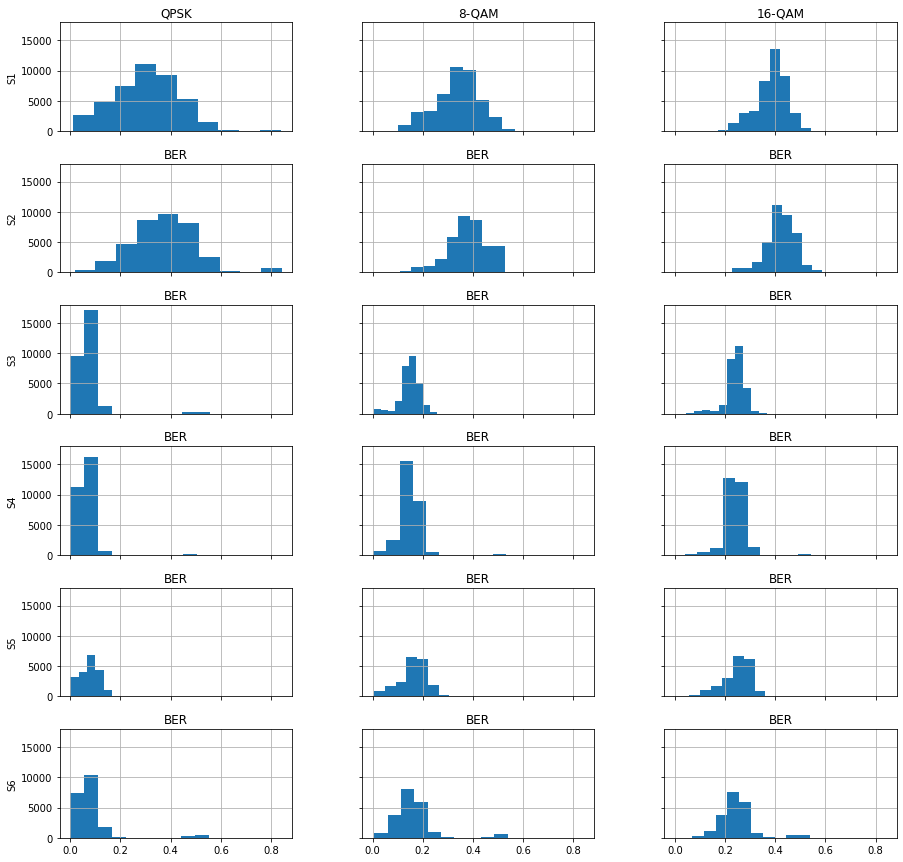

In [ ]:
fig, axes = plt.subplots(6,3,sharex = True, sharey = True, figsize = (15,15))

mods = ['qpsk','8qam','16qam']

for s in range(6):
  for m in range(3):
    filename = mods[m]+'DataS'+str(s+1)+'.csv'
   

    data = pd.read_csv(os.path.join('./SPACE08/',filename))
    data.hist(column = 'BER',ax = axes[s,m])
    




axes[0,0].set_title('QPSK')
axes[0,1].set_title('8-QAM')
axes[0,2].set_title('16-QAM')
axes[0,0].set_ylabel('S1')
axes[1,0].set_ylabel('S2')
axes[2,0].set_ylabel('S3')
axes[3,0].set_ylabel('S4')
axes[4,0].set_ylabel('S5')
axes[5,0].set_ylabel('S6')




#axes[5,0].set_xlabel('Sample number')
#axes[5,1].set_xlabel('Sample number')
#axes[5,2].set_xlabel('Sample number')


plt.show
fig.savefig('BERhist.png')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f5fd753a5c0> has a label of '_' which cannot be automatically added to the legend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f5fd753a6d8> has a label of '_' which cannot be automatically added to the legend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f5fd753a518> has a label of '_' which cannot be automatically added to the legend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f5fd753a320> has a label of '_' which cannot be automatically added to the legend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f5fd7546c88> has a label of '_' w

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

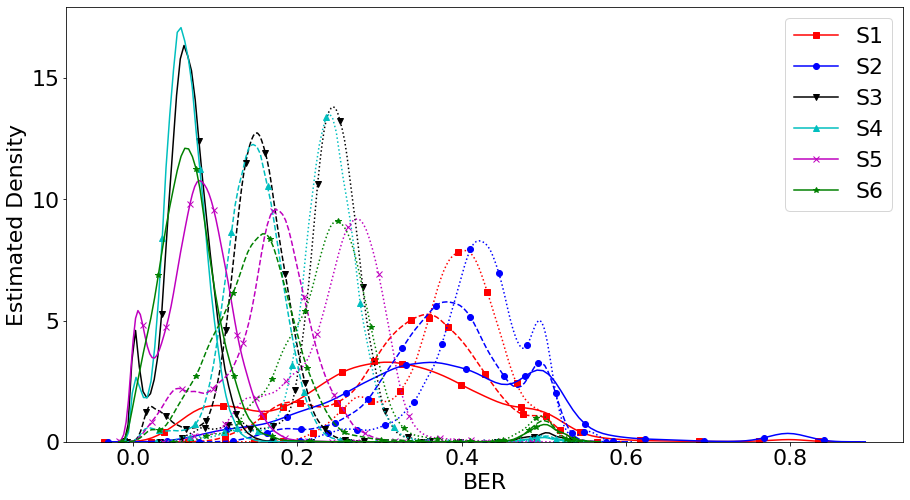

In [ ]:
#fig, axes = plt.subplots(6,3,sharex = True, sharey = True, figsize = (15,15))
fig = plt.figure(figsize = (15,8))
mods = ['qpsk','8qam','16qam']
linestyleM = ['-','--',':']
markerS = ['s','o','v','^','x','*']
colorS = ['r','b','k','c','m','g']
for s in range(6):
  for m in range(3):
    filename = mods[m]+'DataS'+str(s+1)+'.csv'
   

    data = pd.read_csv(os.path.join('./SPACE08/',filename))
    #data.hist(column = 'BER',ax = axes[s,m])
   
    ax = sns.kdeplot(data['BER'],linestyle=linestyleM[m],legend = False, marker = markerS[s],markevery = 10,color = colorS[s])

ax.set_ylabel('Estimated Density')
ax.set_xlabel('BER')


ax.legend(['S1','_','_','S2','_','_','S3','_','_','S4','_','_','S5','_','_','S6','_','_'])

plt.rcParams.update({'font.size':32})

#axes[5,0].set_xlabel('Sample number')
#axes[5,1].set_xlabel('Sample number')
#axes[5,2].set_xlabel('Sample number')


plt.show
fig.savefig('BERhist.png')
files.download('BERhist.png')

In [ ]:

files.download('BERvsTime.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

make plots for classifiers


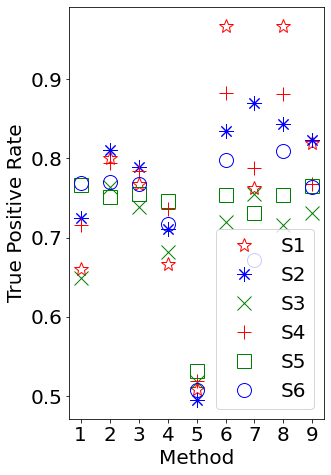

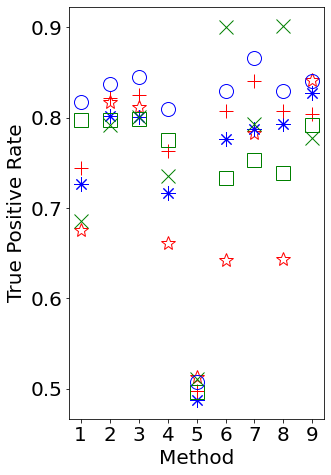

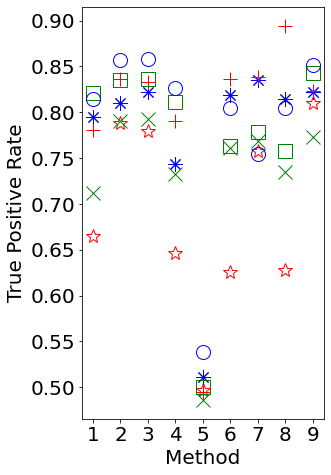

In [ ]:
plt.rcParams.update({'font.size':20})

modelNames = ['Log. Reg','Neural Net 1 layer','Neural Net 2 layer','KNearest Neighbor','ZeroR','Dec. rule','Dec. tree','Naive Bayes','Random Forest']


mods = ['qpsk','8qam','16qam']
markerS = ['*',(8,2,0),'x','+','s','o']
colorS = ['r','b','g','r','g','b']

plotMat = np.zeros([9,6,3])
for s in range(6):
  for m in range(3):
    filename = mods[m]+'DataS'+str(s+1)+'.csv'
    counter = findFileIndex(filename)

    plotMat[:,s,m] = classifierResults[:,0,counter]

#for m in range(3):
  
  
m = 0  
d = {'Model':modelNames,'S1':plotMat[:,0,m],'S2':plotMat[:,1,m],'S3':plotMat[:,2,m],'S4':plotMat[:,3,m],'S5':plotMat[:,4,m],'S6':plotMat[:,5,m]}
fig0, ax = plt.subplots(figsize = (5,7))    
df = pd.DataFrame(d)
for s in range(6):

  g = df.plot(x = 'Model',y = ('S'+str(s+1)),ax = ax,legend=False,marker = markerS[s],color = colorS[s],fillstyle = 'none',linestyle = 'none',ms=14)
    
    

#axes[0].set_title('QPSK')
#axes[1].set_title('8-QAM')
#axes[2].set_title('16-QAM')

ax.set_xticklabels([1,2,3,4,5,6,7,8,9], rotation=0)
ax.set_xticks([0,1,2,3,4,5,6,7,8])
#axes[1].set_xticklabels([1,2,3,4,5,6,7], rotation=0)
#axes[2].set_xticklabels([1,2,3,4,5,6,7], rotation=0)



ax.set_xlabel('Method')
ax.set_ylabel('True Positive Rate')


ax.legend(['S1','S2','S3','S4','S5','S6'])

fig0.tight_layout()
plt.show()
fig0.savefig('classificationTPRqpsk.png')


fig1, ax = plt.subplots(figsize = (5,7))
m = 1  
d = {'Model':modelNames,'S1':plotMat[:,0,m],'S2':plotMat[:,1,m],'S3':plotMat[:,2,m],'S4':plotMat[:,3,m],'S5':plotMat[:,4,m],'S6':plotMat[:,5,m]}
    
df = pd.DataFrame(d)
for s in range(6):

  g = df.plot(x = 'Model',y = ('S'+str(s+1)),ax = ax,legend=False,marker = markerS[s],color = colorS[s],fillstyle = 'none',linestyle = 'none',ms=14)
    
    

#axes[0].set_title('QPSK')
#axes[1].set_title('8-QAM')
#axes[2].set_title('16-QAM')

ax.set_xticklabels([1,2,3,4,5,6,7,8,9], rotation=0)
ax.set_xticks([0,1,2,3,4,5,6,7,8])
#axes[1].set_xticklabels([1,2,3,4,5,6,7], rotation=0)
#axes[2].set_xticklabels([1,2,3,4,5,6,7], rotation=0)


ax.set_xlabel('Method')
ax.set_ylabel('True Positive Rate')


#ax.legend(['S1','S2','S3','S4','S5','S6'])

fig1.tight_layout()
plt.show()
fig1.savefig('classificationTPR8qam.png')







fig2, ax = plt.subplots(figsize = (5,7))
m = 2  
d = {'Model':modelNames,'S1':plotMat[:,0,m],'S2':plotMat[:,1,m],'S3':plotMat[:,2,m],'S4':plotMat[:,3,m],'S5':plotMat[:,4,m],'S6':plotMat[:,5,m]}
    
df = pd.DataFrame(d)
for s in range(6):

  g = df.plot(x = 'Model',y = ('S'+str(s+1)),ax = ax,legend=False,marker = markerS[s],color = colorS[s],fillstyle = 'none',linestyle = 'none',ms=14)
    
    

#axes[0].set_title('QPSK')
#axes[1].set_title('8-QAM')
#axes[2].set_title('16-QAM')

ax.set_xticklabels([1,2,3,4,5,6,7,8,9], rotation=0)
ax.set_xticks([0,1,2,3,4,5,6,7,8])
#axes[1].set_xticklabels([1,2,3,4,5,6,7], rotation=0)
#axes[2].set_xticklabels([1,2,3,4,5,6,7], rotation=0)



ax.set_xlabel('Method')
ax.set_ylabel('True Positive Rate')

#ax.legend(['S1','S2','S3','S4','S5','S6'])

fig2.tight_layout()
plt.show()
fig2.savefig('classificationTPR16qam.png')

In [ ]:
files.download('classificationTPR16qam.png')
files.download('classificationTPR8qam.png')
files.download('classificationTPRqpsk.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

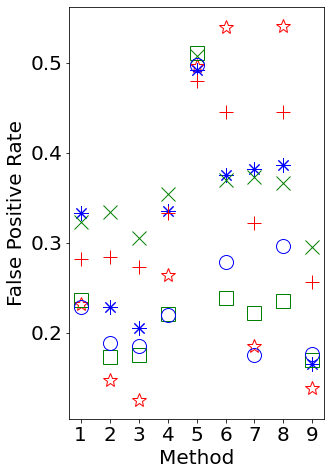

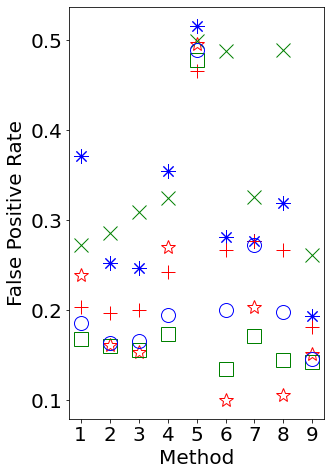

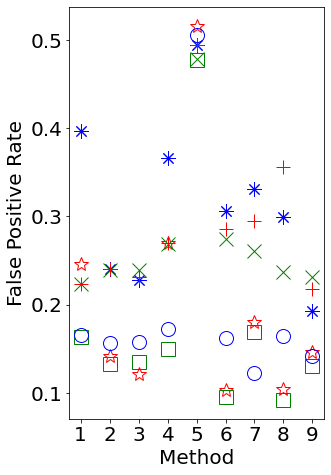

In [ ]:
plt.rcParams.update({'font.size':20})

modelNames = ['Log. Reg','Neural Net 1 layer','Neural Net 2 layer','KNearest Neighbor','ZeroR','Dec. rule','Dec. tree','Naive Bayes','Random Forest']


mods = ['qpsk','8qam','16qam']
markerS = ['*',(8,2,0),'x','+','s','o']
colorS = ['r','b','g','r','g','b']

plotMat = np.zeros([9,6,3])
for s in range(6):
  for m in range(3):
    filename = mods[m]+'DataS'+str(s+1)+'.csv'
    counter = findFileIndex(filename)

    plotMat[:,s,m] = classifierResults[:,1,counter]

#for m in range(3):
  
  
m = 0  
d = {'Model':modelNames,'S1':plotMat[:,0,m],'S2':plotMat[:,1,m],'S3':plotMat[:,2,m],'S4':plotMat[:,3,m],'S5':plotMat[:,4,m],'S6':plotMat[:,5,m]}
fig0, ax = plt.subplots(figsize = (5,7))    
df = pd.DataFrame(d)
for s in range(6):

  g = df.plot(x = 'Model',y = ('S'+str(s+1)),ax = ax,legend=False,marker = markerS[s],color = colorS[s],fillstyle = 'none',linestyle = 'none',ms=14)
    
    

#axes[0].set_title('QPSK')
#axes[1].set_title('8-QAM')
#axes[2].set_title('16-QAM')

ax.set_xticklabels([1,2,3,4,5,6,7,8,9], rotation=0)
ax.set_xticks([0,1,2,3,4,5,6,7,8])
#axes[1].set_xticklabels([1,2,3,4,5,6,7], rotation=0)
#axes[2].set_xticklabels([1,2,3,4,5,6,7], rotation=0)

ax.set_xlabel('Method')
ax.set_ylabel('False Positive Rate')


#ax.legend(['S1','S2','S3','S4','S5','S6'])
fig0.tight_layout()

plt.show()
fig0.savefig('classificationFPRqpsk.png')


fig1, ax = plt.subplots(figsize = (5,7))
m = 1  
d = {'Model':modelNames,'S1':plotMat[:,0,m],'S2':plotMat[:,1,m],'S3':plotMat[:,2,m],'S4':plotMat[:,3,m],'S5':plotMat[:,4,m],'S6':plotMat[:,5,m]}
    
df = pd.DataFrame(d)
for s in range(6):

  g = df.plot(x = 'Model',y = ('S'+str(s+1)),ax = ax,legend=False,marker = markerS[s],color = colorS[s],fillstyle = 'none',linestyle = 'none',ms=14)
    
    

#axes[0].set_title('QPSK')
#axes[1].set_title('8-QAM')
#axes[2].set_title('16-QAM')

ax.set_xticklabels([1,2,3,4,5,6,7,8,9], rotation=0)
ax.set_xticks([0,1,2,3,4,5,6,7,8])
#axes[1].set_xticklabels([1,2,3,4,5,6,7], rotation=0)
#axes[2].set_xticklabels([1,2,3,4,5,6,7], rotation=0)

ax.set_xlabel('Method')
ax.set_ylabel('False Positive Rate')


#ax.legend(['S1','S2','S3','S4','S5','S6'])

fig1.tight_layout()
plt.show()
fig1.savefig('classificationFPR8qam.png')







fig2, ax = plt.subplots(figsize = (5,7))
m = 2  
d = {'Model':modelNames,'S1':plotMat[:,0,m],'S2':plotMat[:,1,m],'S3':plotMat[:,2,m],'S4':plotMat[:,3,m],'S5':plotMat[:,4,m],'S6':plotMat[:,5,m]}
    
df = pd.DataFrame(d)
for s in range(6):

  g = df.plot(x = 'Model',y = ('S'+str(s+1)),ax = ax,legend=False,marker = markerS[s],color = colorS[s],fillstyle = 'none',linestyle = 'none',ms=14)
    
    

#axes[0].set_title('QPSK')
#axes[1].set_title('8-QAM')
#axes[2].set_title('16-QAM')

ax.set_xticklabels([1,2,3,4,5,6,7,8,9], rotation=0)
ax.set_xticks([0,1,2,3,4,5,6,7,8])
#axes[1].set_xticklabels([1,2,3,4,5,6,7], rotation=0)
#axes[2].set_xticklabels([1,2,3,4,5,6,7], rotation=0)


ax.set_xlabel('Method')
ax.set_ylabel('False Positive Rate')

#ax.legend(['S1','S2','S3','S4','S5','S6'])

fig2.tight_layout()
plt.show()
fig2.savefig('classificationFPR16qam.png')

In [ ]:
files.download('classificationFPR16qam.png')
files.download('classificationFPR8qam.png')
files.download('classificationFPRqpsk.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

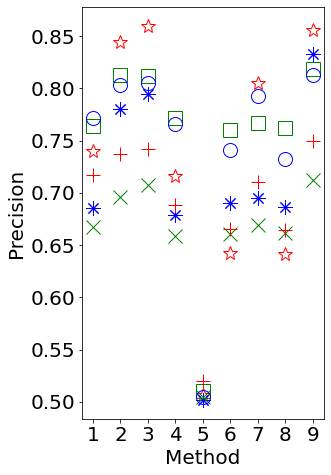

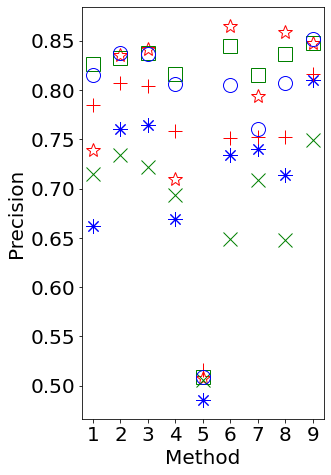

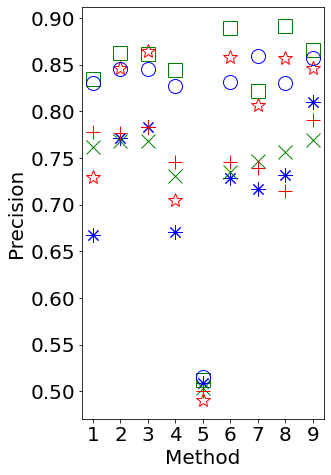

In [ ]:


modelNames = ['Log. Reg','Neural Net 1 layer','Neural Net 2 layer','KNearest Neighbor','ZeroR','Dec. rule','Dec. tree','Naive Bayes','Random Forest']


mods = ['qpsk','8qam','16qam']
markerS = ['*',(8,2,0),'x','+','s','o']
colorS = ['r','b','g','r','g','b']

plotMat = np.zeros([9,6,3])
for s in range(6):
  for m in range(3):
    filename = mods[m]+'DataS'+str(s+1)+'.csv'
    counter = findFileIndex(filename)

    plotMat[:,s,m] = classifierResults[:,2,counter]

#for m in range(3):
  
  
m = 0  
d = {'Model':modelNames,'S1':plotMat[:,0,m],'S2':plotMat[:,1,m],'S3':plotMat[:,2,m],'S4':plotMat[:,3,m],'S5':plotMat[:,4,m],'S6':plotMat[:,5,m]}
fig0, ax = plt.subplots(figsize = (5,7))    
df = pd.DataFrame(d)
for s in range(6):

  g = df.plot(x = 'Model',y = ('S'+str(s+1)),ax = ax,legend=False,marker = markerS[s],color = colorS[s],fillstyle = 'none',linestyle = 'none',ms=14)
    
    

#axes[0].set_title('QPSK')
#axes[1].set_title('8-QAM')
#axes[2].set_title('16-QAM')

ax.set_xticklabels([1,2,3,4,5,6,7,8,9], rotation=0)
ax.set_xticks([0,1,2,3,4,5,6,7,8])
#axes[1].set_xticklabels([1,2,3,4,5,6,7], rotation=0)
#axes[2].set_xticklabels([1,2,3,4,5,6,7], rotation=0)


ax.set_xlabel('Method')
ax.set_ylabel('Precision')


#ax.legend(['S1','S2','S3','S4','S5','S6'])
fig0.tight_layout()

plt.show()
fig0.savefig('classificationPreqpsk.png')


fig1, ax = plt.subplots(figsize = (5,7))
m = 1  
d = {'Model':modelNames,'S1':plotMat[:,0,m],'S2':plotMat[:,1,m],'S3':plotMat[:,2,m],'S4':plotMat[:,3,m],'S5':plotMat[:,4,m],'S6':plotMat[:,5,m]}
    
df = pd.DataFrame(d)
for s in range(6):

  g = df.plot(x = 'Model',y = ('S'+str(s+1)),ax = ax,legend=False,marker = markerS[s],color = colorS[s],fillstyle = 'none',linestyle = 'none',ms=14)
    
    

#axes[0].set_title('QPSK')
#axes[1].set_title('8-QAM')
#axes[2].set_title('16-QAM')

ax.set_xticklabels([1,2,3,4,5,6,7,8,9], rotation=0)
ax.set_xticks([0,1,2,3,4,5,6,7,8])
#axes[1].set_xticklabels([1,2,3,4,5,6,7], rotation=0)
#axes[2].set_xticklabels([1,2,3,4,5,6,7], rotation=0)


ax.set_xlabel('Method')
ax.set_ylabel('Precision')


#ax.legend(['S1','S2','S3','S4','S5','S6'])

fig1.tight_layout()
plt.show()
fig1.savefig('classificationPre8qam.png')







fig2, ax = plt.subplots(figsize = (5,7))
m = 2  
d = {'Model':modelNames,'S1':plotMat[:,0,m],'S2':plotMat[:,1,m],'S3':plotMat[:,2,m],'S4':plotMat[:,3,m],'S5':plotMat[:,4,m],'S6':plotMat[:,5,m]}
    
df = pd.DataFrame(d)
for s in range(6):

  g = df.plot(x = 'Model',y = ('S'+str(s+1)),ax = ax,legend=False,marker = markerS[s],color = colorS[s],fillstyle = 'none',linestyle = 'none',ms=14)
    
    

#axes[0].set_title('QPSK')
#axes[1].set_title('8-QAM')
#axes[2].set_title('16-QAM')

ax.set_xticklabels([1,2,3,4,5,6,7,8,9], rotation=0)
ax.set_xticks([0,1,2,3,4,5,6,7,8])
#axes[1].set_xticklabels([1,2,3,4,5,6,7], rotation=0)
#axes[2].set_xticklabels([1,2,3,4,5,6,7], rotation=0)


ax.set_xlabel('Method')
ax.set_ylabel('Precision')

#ax.legend(['S1','S2','S3','S4','S5','S6'])
fig2.tight_layout()

plt.show()
fig2.savefig('classificationPre16qam.png')

In [ ]:
files.download('classificationPre16qam.png')
files.download('classificationPre8qam.png')
files.download('classificationPreqpsk.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

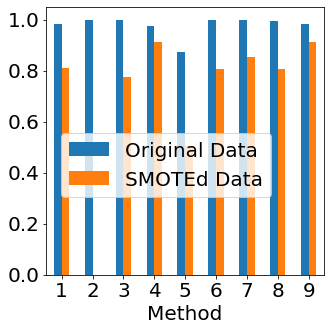

In [ ]:
plt.rcParams.update({'font.size':20})


fig, ax = plt.subplots(figsize = (5,5))
counter = 0
modelNames = ['Log. Reg','Neural Net 1 layer','Neural Net 2 layer','KNearest Neighbor','ZeroR','Dec. rule','Dec. tree','Naive Bayes','Random Forest']

results = np.stack((np.squeeze(origResults),np.squeeze(smoteResults)),axis=2)

d1 = {'Method':modelNames,'Original Data':results[:,0,0],'SMOTEd Data':results[:,0,1]}
df1 = pd.DataFrame(d1)






#df.plot.bar(x = 'Model',y = 'Mean Squared Error')  
df1.plot.bar(x = 'Method',ax = ax,legend=False)



#df.plot.bar(x = 'Model',y = 'Recall', ax = axes[3],legend=False)




ax.set_xticklabels([1,2,3,4,5,6,7,8,9], rotation=0)
#axes[3].set_xticklabels([1,2,3,4,5,6,7,8,9], rotation=0)



#ax.set_title('TPR')
#axes[3].set_title('Recall')
fig.tight_layout()
fig.legend(loc=10)




plt.savefig('KW14classSMOTETPR.png')
files.download('KW14classSMOTETPR.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

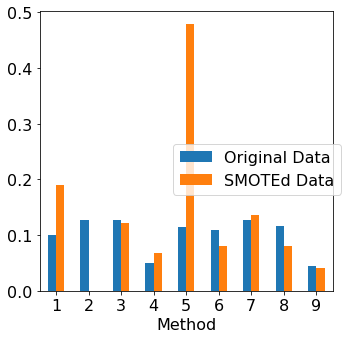

In [ ]:
fig, ax = plt.subplots(figsize = (5,5))
counter = 0
modelNames = ['Log. Reg','Neural Net 1 layer','Neural Net 2 layer','KNearest Neighbor','ZeroR','Dec. rule','Dec. tree','Naive Bayes','Random Forest']

results = np.stack((np.squeeze(origResults),np.squeeze(smoteResults)),axis=2)

d1 = {'Method':modelNames,'Original Data':results[:,1,0],'SMOTEd Data':results[:,1,1]}
df1 = pd.DataFrame(d1)






#df.plot.bar(x = 'Model',y = 'Mean Squared Error')  
df1.plot.bar(x = 'Method',ax = ax,legend=False)



#df.plot.bar(x = 'Model',y = 'Recall', ax = axes[3],legend=False)




ax.set_xticklabels([1,2,3,4,5,6,7,8,9], rotation=0)
#axes[3].set_xticklabels([1,2,3,4,5,6,7,8,9], rotation=0)



#ax.set_title('TPR')
#axes[3].set_title('Recall')
fig.tight_layout()
fig.legend(loc=5)





plt.savefig('KW14classSMOTEFPR.png')
files.download('KW14classSMOTEFPR.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

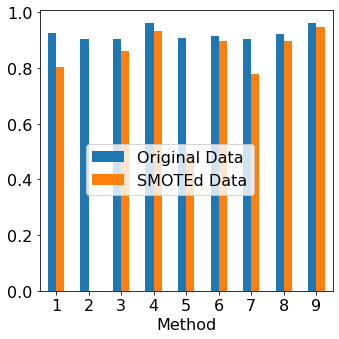

In [ ]:
fig, ax = plt.subplots(figsize = (5,5))
counter = 0
modelNames = ['Log. Reg','Neural Net 1 layer','Neural Net 2 layer','KNearest Neighbor','ZeroR','Dec. rule','Dec. tree','Naive Bayes','Random Forest']

results = np.stack((np.squeeze(origResults),np.squeeze(smoteResults)),axis=2)

d1 = {'Method':modelNames,'Original Data':results[:,2,0],'SMOTEd Data':results[:,2,1]}
df1 = pd.DataFrame(d1)






#df.plot.bar(x = 'Model',y = 'Mean Squared Error')  
df1.plot.bar(x = 'Method',ax = ax,legend=False)



#df.plot.bar(x = 'Model',y = 'Recall', ax = axes[3],legend=False)




ax.set_xticklabels([1,2,3,4,5,6,7,8,9], rotation=0)
#axes[3].set_xticklabels([1,2,3,4,5,6,7,8,9], rotation=0)



#ax.set_title('TPR')
#axes[3].set_title('Recall')
fig.tight_layout()
fig.legend(loc=10)





plt.savefig('KW14classSMOTEPre.png')
files.download('KW14classSMOTEPre.png')

Make a .csv with data dimensions to import into table in figure

In [ ]:


mods = ['qpsk','8qam','16qam']


numPoints = np.zeros([3,6])
for s in range(6):
  for m in range(3):
    filename = mods[m]+'DataS'+str(s+1)+'.csv'
    data = pd.read_csv(os.path.join('./SPACE08/',filename))
    
    counter = findFileIndex(filename)
    #print( regressionResults[:,0,counter])
    numPoints[m,s] = data.shape[0]
np.savetxt('dataDim.csv',numPoints, fmt = '%d',delimiter=',')
files.download('dataDim.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>